(sec:exercise-ogura)=
# 演習2 - 百人一首エージェントを作る

今回の演習では、小倉百人一首をプレイヤーAIを作成してみよう。ご存じの通り、小倉百人一首は、100種類の短歌からなる「かるた」の一種であり、読み札は短歌の上の句 (5・7・5の部分)であり、取り札が下の句(7・7の部分)である。

:::{note}

「かるた」とは、取り札を床の上に並べて、読み手が読んだ読み札に対応する取り札に一番早く触れた人が取り札を取るというゲームである。全ての読み札を読み終えた時点で最も多くの取り札をもっていた人が勝ちとなる。

:::

通常の小倉百人一種では、読み札には上の句と下の句の両方が漢字で書かれており、さらに挿絵がある。一方で取り札は下の句が濁点や半濁点を含まないひらがな46種類によって書かれている。

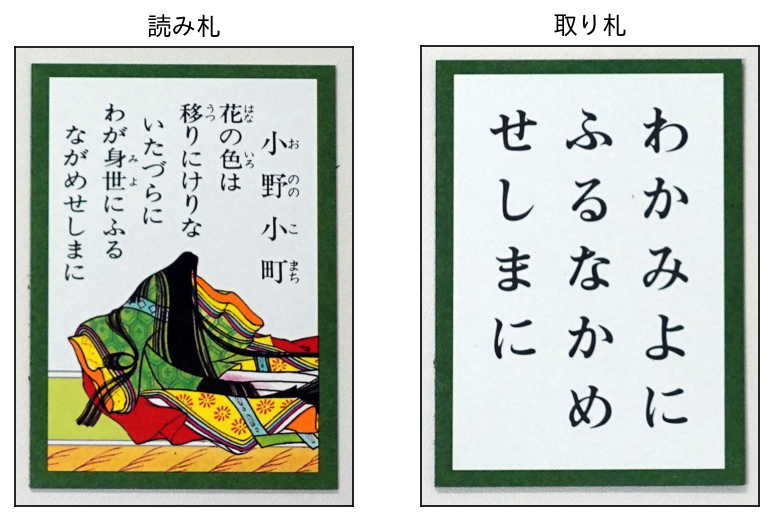

In [4]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import japanize_matplotlib

matplotlib.rcParams["figure.dpi"] = 150

yomi = cv2.imread("../../data/ogura/yomifuda.jpg", cv2.IMREAD_COLOR)
tori = cv2.imread("../../data/ogura/torifuda.jpg", cv2.IMREAD_COLOR)

fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(yomi[:, :, ::-1])
ax.set(xticks=[], yticks=[], title="読み札")

ax = fig.add_subplot(122)
ax.imshow(tori[:, :, ::-1])
ax.set(xticks=[], yticks=[], title="取り札")

plt.show()

百人一首では100枚の札のうち50枚だけを並べて、それを2人のプレイヤーによって取り合う。読み札は100枚全てを用いるので、「空札」といって、読まれたけれども50枚の取り札には含まれない札というのも存在する。

細かな百人一首のルールについては、以下の全日本かるた協会のウェブサイトを参考にしてほしい。

**はじめての競技かるた:** <https://www.karuta.or.jp/karuta/first-time/>

## 演習の内容

今回の演習では、取り札が複数含まれた画像と、上の句を表す文字列の先頭数文字が与えられる。例えば、以下のような画像と文字列のペアが与えられる。

**入力画像:**


**入力文字列:**

```
はなのいろは  
あさぼらけ  
ほととぎす
```

この入力に対して、各行のひらがなの列に対して、取り札が一つに決まり、なおかつ、その札が画像に含まれる場合には`1`を、与えられた文字列では札が決まらない場合は`2`を、対応する取り札が存在しない場合には`0`を返すようにする。

例えば、上の入力例では、「はなのいろは...」で始まる句は決まり字が3文字の「はなの」であり、なおかつ下の句である「わかみよにふる なかめせしまに」と書かれた札が画像に映っているので`1`が正解となる。

一方、2つめの「あさぼらけ」は2枚しかない6文字決まり字の札であり、「あさぼらけ ありあけのつきと...」に対応する下の句である「よしののさとに ふれるしらゆき」と、「あさぼらけ うじのかわぎり...」に対応する下の句である「あらはれわたる せせのあしろき」の両方が画像に含まれており、どちらの札を取れば良いかが決まらない。従って正解は`2`となる。

3つ目の「ほとどぎす」は1文字決まりの札であるため、対応する下の句が「たたありあけの つきそのこれる」になることは決定しているが、その下の句の札は画像中に存在しないため、正解は`0`となる。

以上より、上記の入力に対する正しい出力の例は以下のようになる。

**出力:**

```
1
2
0
```

これらを踏まえて、以下のような**画像 (image)** と **文字列の配列 (poems)** および問題のレベル (level)をとって、各和歌の決まりの状況を示す配列 (各要素は0-2)を返す以下の関数を実装すること。

```python
def ogura(image: NDArray[np.uint8], poems: List[str], level: int) -> List[int]:
    """
    Inputs:
      image: input image
      poems: list of ogura poems
      level: difficulty level of this problem (1-3)
    Outputs:
      answer: list of determination status
        0: specific poem does not exist in the image
        1: possible poem can exist in the image, but there remains other possible poems
        2: the specific poem exist in the card, and there is no other possible poems
    """
    return [0] * len(poems)
```

### 問題のレベル

今回の演習では、以下の3つのレベルの入力を用意している。

- **レベル1:** 画像に写っている取り札は1枚だけであり、読み札に対応する文字列も1つだけが与えられる。
- **レベル2:** 画像に写っている取り札は3枚以上、5枚以下であり、読み札に対応する文字列は3つが与えられる。
- **レベル3:** 画像に写っている取り札は不特定多数であり、読み札に対応する文字列は最大5つ与えられる。

これら、各レベルの入力が10枚ずつ与えられ、レベルに対応する点数、すなわちレベル1なら1点、レベル2なら2点、レベル3なら3点が、出力が完璧に正しい場合にのみ与えられる(したがって部分点はない)。実際に与えられる画像の例は以下の通り。

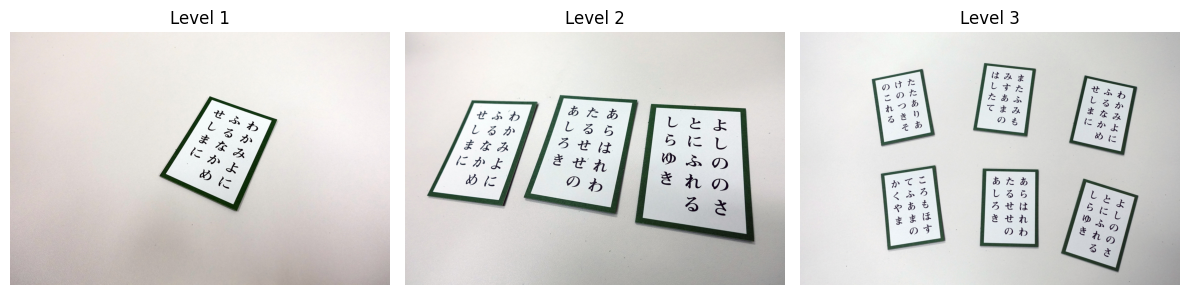

In [60]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

level1 = cv2.imread("../../data/ogura/level1.jpg")[:, :, ::-1]
level2 = cv2.imread("../../data/ogura/level2.jpg")[:, :, ::-1]
level3 = cv2.imread("../../data/ogura/level3.jpg")[:, :, ::-1]

fig = plt.figure(figsize=(12, 4))

a1 = level1.shape[1] / level1.shape[0]
a2 = level2.shape[1] / level2.shape[0]
a3 = level3.shape[1] / level3.shape[0]

# create subplots
gs = gridspec.GridSpec(1, 3, width_ratios=[a1, a2, a3])
p1 = plt.subplot(gs[0])
p2 = plt.subplot(gs[1])
p3 = plt.subplot(gs[2])

p1.imshow(level1)
p1.axis("off")
p1.set_title("Level 1")

p2.imshow(level2)
p2.axis("off")
p2.set_title("Level 2")

p3.imshow(level3)
p3.axis("off")
p3.set_title("Level 3")

plt.tight_layout()
plt.show()

**使用可能なライブラリ**

今回の実行環境では、以下のライブラリが使用可能となっている (Pipを使ってインストールされる)。これ以外のライブラリは使用できないので注意すること。

- numpy
- scikit-learn
- matplotlib
- pandas
- opencv-python
- pytorch-cpu

上記の通り、実行環境においてはCPU版を用いるが、学習はGoogle Colab上などでGPUを用いて行っても良い。その場合、デバイスが学習環境と実行環境で異なるため、`torch.load`の引数に`map_location=...`を指定するのを忘れないようにすること。

**テスト方法**

まずは、各レベル5問ずつ練習データを提供するので、それを用いてテストを行うと良い。以下のURLからZIPファイルをダウンロードして、講義中に伝えるパスワードで展開して使うこと。

- [百人一首演習 - 練習用データ](https://github.com/tatsy-classes/ogura-agent-template/raw/master/data/samples.zip)

本番の採点はGitHub Classroomを使って行う。講義中で課題用のClassroomのURLを指示するので、そのURLをブラウザで開き、テンプレートレポジトリを自分のGitHubアカウントと紐付ける。以後、課題用のレポジトリにコードをpushする度にテストが走る。

本講義では、実際の問題として与えている画像を公開することはしないが、どの程度の画像に対してプログラムが正しく動いているかは、Github Actionsのログを見ることで確認できる。

## より高度な問題を解くヒント

小倉百人一首には、上の句にも下の句にも決まり字がある。一例として、

- はなのいろは うつりにけりな いたずらに わかみよにふる なかめせしまに

という句であれば、上の句の決まり字は「はなの」であり、下の句の決まり字は「わかみよ」である。

従って、厳密には、画像に写った読み札に書かれた文字全てを認識する必要はなく、札の右上の方に書かれた数文字だけを認識できれば十分である。もちろん、識別の精度は100%にはならないと思われるので、多めに文字を認識して、間違いがないようにする方が良い。

また、今回の演習では、画像の中に複数の取り札が含まれている可能性がある (その代わり画像中に読み札以外の余計なものをは写っていない)ため、それらを全て画像として取り出す必要がある。しかも札の向きは任意であるため、ひらがなを認識できるような札の向きにどのように揃えるかは一つポイントになるだろう。

今回も、データセットの作成には、[数独の演習](sec:exercise-sudoku)で用いたようなExcelやGoogleスプレッドシートを用いる方法が使える。今回は46文字のひらがなだけが対象であるので、以下の画像のように1行ごとに41文字を並べて、各行を異なるフォントにしてデータセットを作れば良いだろう (やはり、受講者同士で協力してデータセットを作って良い)。

```{image} ./imgs/gen_hira_excel.jpg
:align: center
```

<br/>

また、よりプログラム的な方法としてPillowの`ImageDraw`を用いる方法もある。例えば、背景が白の画像を用意して、以下のように平仮名を書き込むことができる。

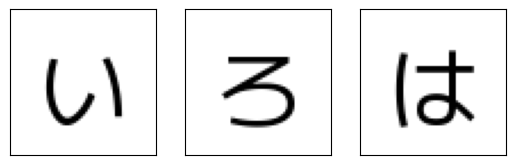

In [59]:
from PIL import Image, ImageDraw, ImageFont

h, w = 64, 64
text = ["い", "ろ", "は"]
font = ImageFont.truetype("./fonts/MPLUS1-Regular.ttf", 40)

imgs = []
for t in text:
    img = Image.new("L", (w, h), "white")
    draw = ImageDraw.Draw(img)
    draw.text((w // 2, h // 2), t, fill="black", font=font, anchor="mm")
    imgs.append(np.array(img))

fig = plt.figure()

ax = fig.add_subplot(131)
ax.set(xticks=[], yticks=[])
ax.imshow(imgs[0], cmap="gray")

ax = fig.add_subplot(132)
ax.set(xticks=[], yticks=[])
ax.imshow(imgs[1], cmap="gray")

ax = fig.add_subplot(133)
ax.set(xticks=[], yticks=[])
ax.imshow(imgs[2], cmap="gray")

plt.show()

日本語用のフォントについては、各自のシステムにインストールされているフォントを使うか、あるいは[Google Fonts](https://fonts.google.com/?subset=japanese&noto.script=Hira)で日本語用のフォントをダウンロードして使用するのも良いだろう。